Домашнее задание #2. Парсинг

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options

**Задача** - собрать данные по всем текущим преподавателям всех `институтских кафедр` МФТИ.

Собранный датасет должен представлять из себя `.csv` файл со следующими полями:

* `full_name` - ФИО преподавателя
* `birth_day` - Дата рождения преподавателя
*  `teach_place` - Кафедра
*  `degree`- Ученая Степень
* `knowledge` - Знания
*  `teaching_skill` - Умение преподавать
* `commication_skill` - В общении
* `easy_exam` - «Халявность»
* `overall_score` - Общая оценка



0. Открываем с помощью Selenium клавную страницу вики-Физтех- http://wikimipt.org/wiki/

In [5]:
path_CDM = 'data/chromedriver'
url = 'http://wikimipt.org/wiki/'

options = Options()
options.headless = True
browser = webdriver.Chrome(ChromeDriverManager().install(), options=options)
browser.get(url)


# 1. Получаем список кафедр с главной страницу вики-Физтех

titles = browser.find_elements_by_xpath('//*[@class="mw-headline"]')
faculties = []
# ищем Институтские кафедры, потом его родителя должно быть <h3>, затем брата div, и его список - это и есть кафедры
for i in titles:
    if i.text == 'Институтские кафедры':
        faculties = i.find_elements_by_xpath('../following-sibling::div/ul/li/a')

# берем из каждой кафедры ссылку и атрибут class - он нам нужен будет для проверки существования страницы кафедры
faculties = [{'url': f.get_attribute('href'), 'cls': f.get_attribute('class'), 'txt': f.text} for f in faculties]

# Обходя список кафедр, "проваливаемся" в каждую страницу кафедру кликом по названию кафедры
# реализовать это у меня не получилось - я натыкался на ошибку element is not attached to page document
# (StaleElementReferenceException), поэтому пришлось сохранять ссылки на кафедры, а затем преподавателей в массив...

# 2. Получаем список преподавателей
all_teachers = {}
following = '(../following-sibling::div)[1]'

for f in faculties:
    if f.get('cls') == 'new':
        print(f'{f.get("txt")} page not exist')
        continue
    browser.get(f.get('url'))
    titles = browser.find_elements_by_xpath('//*[@class="mw-headline"]')
    title_teachers = None
    for t in titles:
        if t.text == 'Преподаватели кафедры':
            title_teachers = t
    if not title_teachers:
        print(f'Department: {f.get("url")} has no teacher title')
        continue
    following_el = title_teachers.find_element_by_xpath(following)
    cls = following_el.get_attribute('class')

    # на первых двух кафедрах список преподавателей оформлен простым списком, на остальных это класс gallery с фотографиями
    if cls == 'srf-gallery srf-redirect':
        xpath_teachers = f'{following}/ul//*[@class="gallerytext"]//a'
    else:
        xpath_teachers = f'{following}/ul//a'

    teachers = title_teachers.find_elements_by_xpath(xpath_teachers)
    all_teachers[f.get('txt')] = [t.get_attribute('href') for t in teachers]

print('All teacher hrefs received')

teacher_info = {
    'full_name': None,
    'birth_day': None,
    'teach_place': None,
    'degree': None,
    'knowledge': None,
    'teaching_skill': None,
    'communication_skill': None,
    'easy_exam': None,
    'overall_score': None
}
df = pd.DataFrame(columns=[col for col in teacher_info.keys()])


def update_teacher_info(title, key):
    rate = title.find_element_by_xpath('following-sibling::td//*[@class="starrating-avg"]').text
    try:
        teacher_info[key] = float(rate.split()[0])
    except (IndexError, AttributeError, ValueError):
        pass

# Обходя список преподавателей "Проваливаемся" на страницу преподавателя по ФИО преподавателя
# 3. Получаем табличку данных с характеристиками преподавателями и прочую необходимую информацию.

for faculty, teachers in all_teachers.items():
    for teacher_href in teachers:

        browser.get(teacher_href)

        teacher_info['full_name'] = browser.find_element_by_id("firstHeading").text
        brt_dgr = browser.find_elements_by_xpath('//*[@class="wikitable card"]//th')
        for t in brt_dgr:

            if t.text == 'Дата рождения':
                birthday = t.find_element_by_xpath('following-sibling::td').text
                teacher_info['birth_day'] = birthday
            if t.text == 'Учёная степень':
                degree = t.find_element_by_xpath('following-sibling::td').text
                teacher_info['degree'] = degree.rsplit(' ', 1)[0]

        teacher_info['teach_place'] = faculty

        other = browser.find_elements_by_xpath('//*[@class="wikitable card"]//table//td')

        for o in other:
            if o.text == 'Знания':
                update_teacher_info(o, 'knowledge')
            if o.text == 'Умение преподавать':
                update_teacher_info(o, 'teaching_skill')
            if o.text == 'В общении':
                update_teacher_info(o, 'communication_skill')
            if o.text == '«Халявность»':
                update_teacher_info(o, 'easy_exam')
            if o.text == 'Общая оценка':
                update_teacher_info(o, 'overall_score')

        # Сохраняем данные в pandas DataFrame
        df = df.append(teacher_info, ignore_index=True)

    print(f'Faculty {faculty} has parsed')

browser.quit()
print('All data received')



====== WebDriver manager ======
Current google-chrome version is 96.0.4664
Get LATEST chromedriver version for 96.0.4664 google-chrome
Driver [C:\Users\Skygen\.wdm\drivers\chromedriver\win32\96.0.4664.45\chromedriver.exe] found in cache
C:\Users\Skygen\AppData\Local\Temp/ipykernel_4712/3494093987.py:6: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser = webdriver.Chrome(ChromeDriverManager().install(), options=options)
C:\Users\Skygen\AppData\Local\Temp/ipykernel_4712/3494093987.py:12: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  titles = browser.find_elements_by_xpath('//*[@class="mw-headline"]')
d:\mipt\mipt-datascience\venv\lib\site-packages\selenium\webdriver\remote\webelement.py:426: UserWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  warnings.warn("find_elements_by_* commands are deprecated. Please use find_elements() instead")
C:\Us

Кафедра биофизики и экологии page not exist
Faculty Кафедра высшей математики parsed
Faculty Кафедра общей физики parsed
Faculty Кафедра общей химии parsed
Faculty Кафедра информатики parsed
Faculty Кафедра иностранных языков parsed
Faculty Кафедра вычислительной математики parsed
Faculty Кафедра теоретической физики parsed
Faculty Кафедра теоретической механики parsed
Faculty Кафедра радиотехники и телекоммуникаций parsed
Faculty Кафедра прикладной механики parsed
Faculty Кафедра права parsed
Faculty Кафедра физического воспитания и спорта parsed
Faculty Кафедра системного анализа экономики parsed
Faculty Военная кафедра parsed
Faculty Кафедра философии parsed
Faculty Высшая школа системного инжиниринга parsed


Делаем дамп из датафрейма в csv file

In [6]:

# сохраняем в csv
df.to_csv(r'data/mipt_teachers.csv', header=True, sep=';', index=False)

Кластеризация

Выбираем количество кластеров

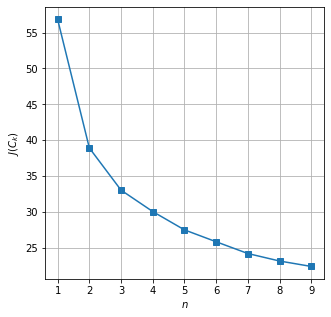

In [44]:
X = df.copy()

# оставляем численные признаки
X = X.drop(labels=['degree', 'teach_place', 'full_name', 'birth_day'], axis=1)

# чистим датасет
X = X.dropna()
inertia = []

_range = range(1, 10)

for i  in _range:
    kmeans = KMeans(n_clusters=i, random_state=42).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.figure(figsize=(5, 5))
plt.plot(_range, inertia, marker='s')
plt.grid(visible=True)
plt.xlabel('$n$')
plt.ylabel('$J(C_k)$')
plt.show()

Из графика видно, что J(Ck) падает сильно с (1 до 2) и (2 до 3), с 3 до 4 уже не так сильно, поэтому оптимальное  = 3

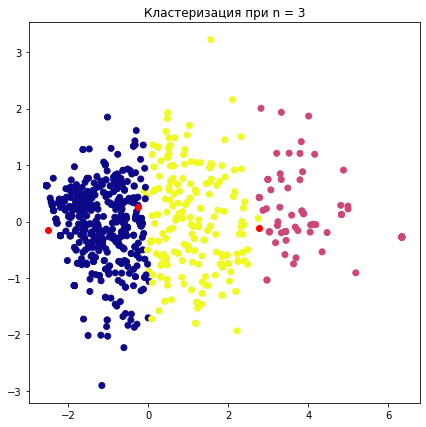

In [55]:
data_x_y = PCA(n_components=2, random_state=42).fit_transform(X)

clusterer = KMeans(n_clusters=3, random_state=42)
cluster_labels = clusterer.fit_predict(X)
data_x_y_cluster_centers = PCA(n_components=2, random_state=42).fit_transform(clusterer.cluster_centers_)

plt.figure(figsize=(7, 7))
plt.scatter(data_x_y[:,0], data_x_y[:,1], c=cluster_labels, cmap ='plasma')
plt.scatter(data_x_y_cluster_centers[:,0], data_x_y_cluster_centers[:,1], color='red')
plt.title(f'Кластеризация при n = {3}')
plt.show()